# This is a scratch space for building functions
After functions are made, move them to the corresponding folder. 

In [29]:
from openpiv import tools, pyprocess, validation, filters, scaling
from pathlib import Path
import importlib_resources
from video_manipulation.segment_skel import segment_brightfield_ultimate
import cv2

import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

path = importlib_resources.files('openpiv')

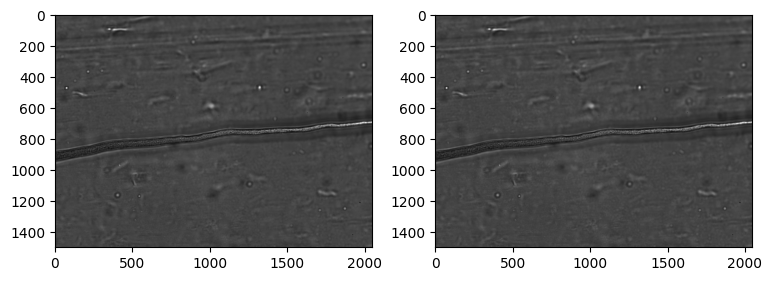

In [30]:
frame_a_path = Path(r"/scratch-shared/amftrack_prod/test_data/20250122_Plate017/033/Img/Img_00000.tif")
frame_b_path = Path(r"/scratch-shared/amftrack_prod/test_data/20250122_Plate017/033/Img/Img_00002.tif")

frame_a = imread(frame_a_path)
frame_b = imread(frame_b_path)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(frame_a, cmap=plt.cm.gray)
axs[1].imshow(frame_b, cmap=plt.cm.gray)
plt.show()

fps = 20 / 2
t_dt = 1/fps
winsize = 8 # pixels, interrogation window size in frame A
searchsize = 10  # pixels, search area size in frame B
overlap = 2 # pixels, 50% overlap
dt = t_dt # sec, time interval between the two frames


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


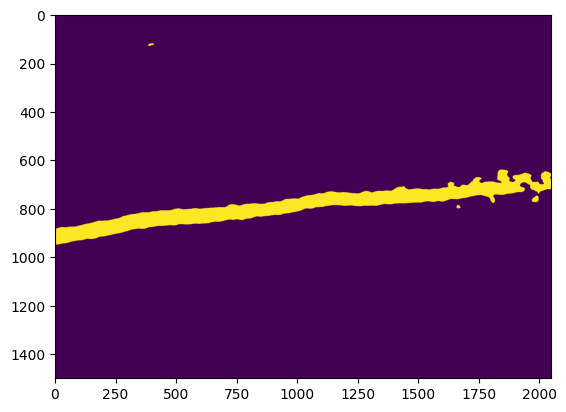

In [31]:
segmented_im = segment_brightfield_ultimate([frame_a_path, frame_b_path])
print(segmented_im)
fig, ax = plt.subplots()
ax.imshow(segmented_im)

In [32]:
u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frame_a.astype(np.int32),
    frame_b.astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)
x, y = pyprocess.get_coordinates(
    image_size=frame_a.shape,
    search_area_size=searchsize,
    overlap=overlap,
)

In [33]:
STN_thresh = 1.4

invalid_mask = validation.sig2noise_val(
    sig2noise,
    threshold = STN_thresh,
)
destined_shape = invalid_mask.shape

segmented_im = cv2.resize(segmented_im, destined_shape[::-1])
segmented_im = np.where(segmented_im > 1, True, False)

invalid_mask  = ~(invalid_mask * segmented_im)

u2, v2 = filters.replace_outliers(
    u0, v0,
    invalid_mask,
    method='localmean',
    max_iter=3,
    kernel_size=3,
)
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(
    x, y, u2, v2,
    scaling_factor = 1501,  # 96.52 pixels/millimeter
)

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)
tools.save('exp1_001.txt' , x, y, u3, v3, invalid_mask)


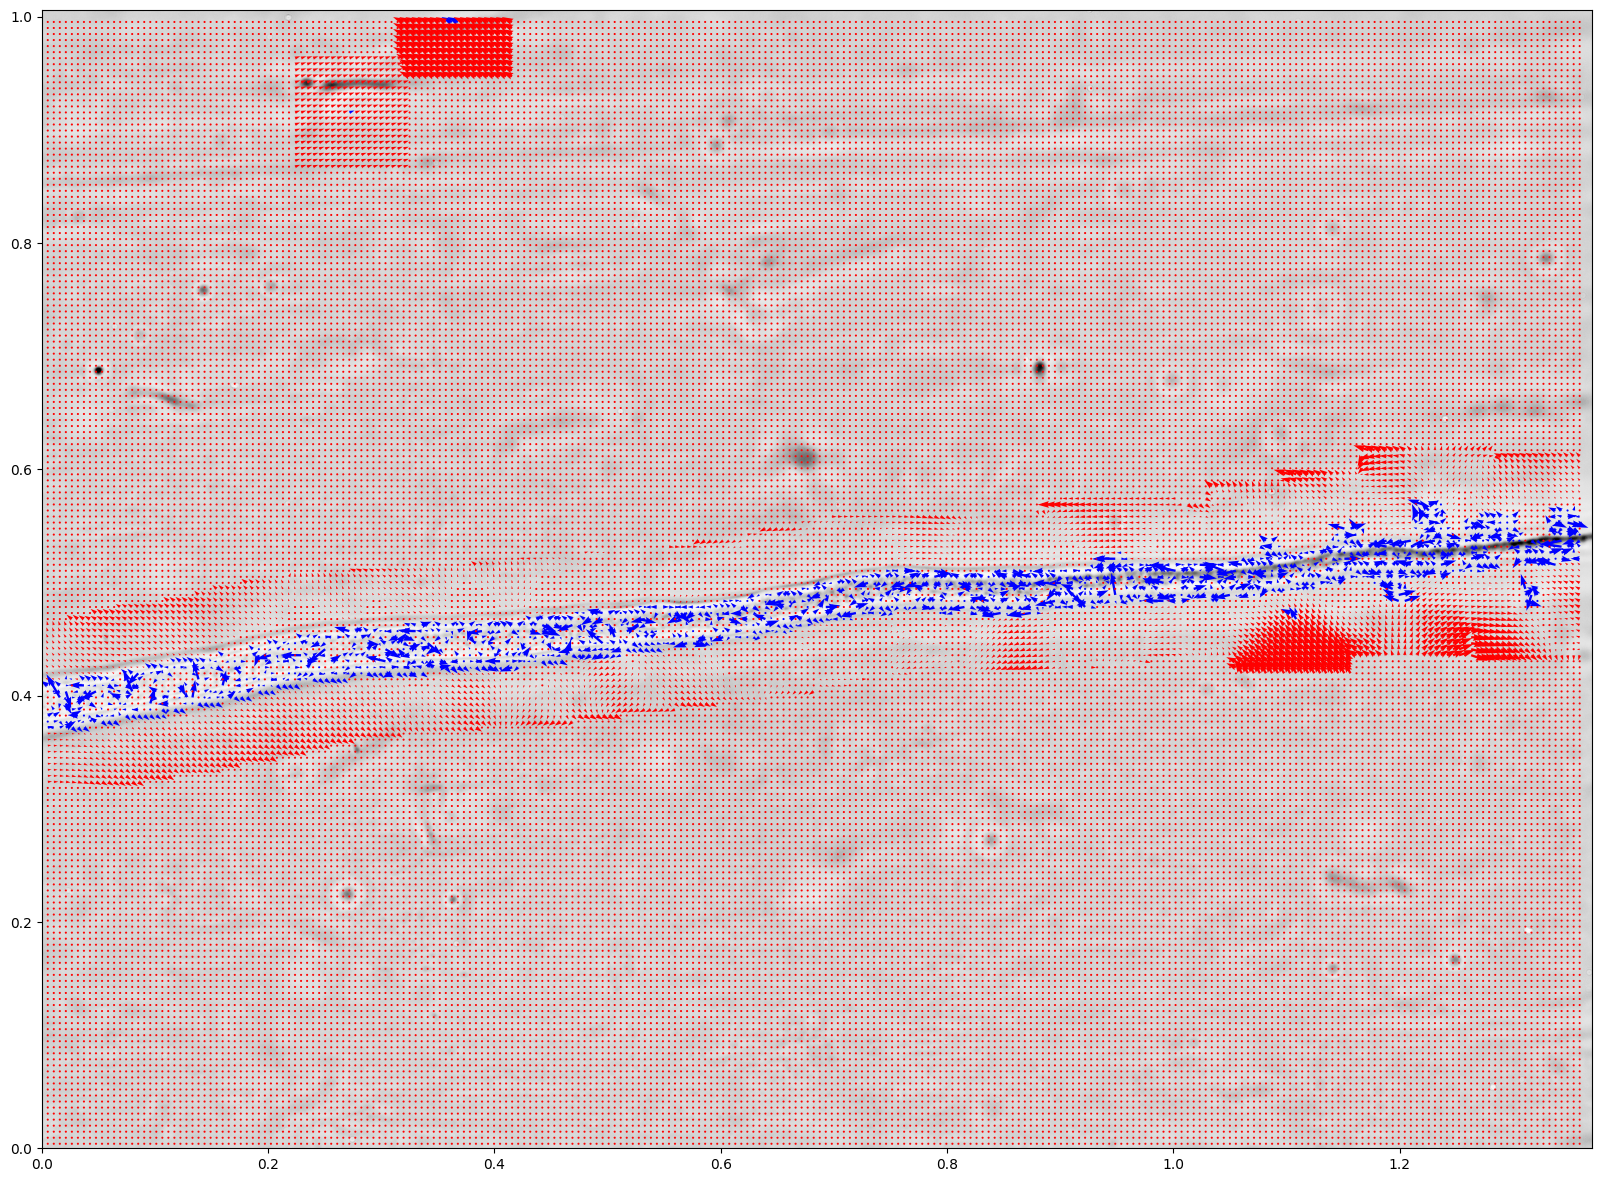

In [34]:
fig, ax = plt.subplots(figsize=(20,20))
tools.display_vector_field(
    Path('exp1_001.txt'),
    ax=ax, scaling_factor=1501,
    scale=2, # scale defines here the arrow length
    width=0.0015, # width is the thickness of the arrow
    on_img=True, # overlay on the image
    image_name= "/scratch-shared/amftrack_prod/test_data/20250122_Plate017/033/Img/Img_00000.tif",
);